In [17]:
#%pip install strawberryfields --upgrade
import numpy as np
import strawberryfields as sf
import matplotlib.pyplot as plt
import time
from strawberryfields import RemoteEngine
from strawberryfields.ops import *
from random import shuffle
from random import seed
from collections import OrderedDict

In [18]:
start_BS_Time = time.time()

#We create an 4-mode quantum program
boson_sampling = sf.Program(4) 

with boson_sampling.context as q:
    # prepare the input fock states
    Fock(1) | q[0]
    Fock(1) | q[1]
    Fock(1) | q[2]
    Vac     | q[3]
    
    # rotation gates
    Rgate(0.5719)  | q[0]
    Rgate(-1.9782) | q[1]
    Rgate(2.0603)  | q[2]
    Rgate(0.0644)  | q[3]

    # beamsplitter array
    BSgate(0.7804, 0.8578)  | (q[0], q[1])
    BSgate(0.06406, 0.5165) | (q[2], q[3])
    BSgate(0.473, 0.1176)   | (q[1], q[2])
    BSgate(0.563, 0.1517)   | (q[0], q[1])
    BSgate(0.1323, 0.9946)  | (q[2], q[3])
    BSgate(0.311, 0.3231)   | (q[1], q[2])
    BSgate(0.4348, 0.0798)  | (q[0], q[1])
    BSgate(0.4368, 0.6157)  | (q[2], q[3])
    
eng = sf.Engine(backend="fock", backend_options={"cutoff_dim": 7})
#eng = sf.RemoteEngine("X8", backend_options={"cutoff_dim": 7})

# We can now execute the program with the engine:
results = eng.run(boson_sampling, shots=400000)

# extract the joint Fock probabilities
probs = results.state.all_fock_probs()
#probs1 = results.state

#Calculate Time of Boson Samplers
end_BS_Time = time.time()
my_BS_Time = end_BS_Time - start_BS_Time
print("The execution time for Boson Samplers is :", my_BS_Time)


The execution time for Boson Samplers is : 25.476024866104126


|0003>: 0.0036948559765504515
|0012>: 0.027129675723311982
|0021>: 0.06502962145115693
|0030>: 0.050733771611210274
|0102>: 0.002602727441190584
|0111>: 0.01107027525231426
|0120>: 0.010862085413282391
|0201>: 0.0351637098808715
|0210>: 0.04193914564650369
|0300>: 0.15646928742727867
|1002>: 0.01309808123756603
|1011>: 0.05586339993711769
|1020>: 0.0546071093851579
|1101>: 0.04560721169037526
|1110>: 0.0960897483373251
|1200>: 0.031975838515474565
|2001>: 0.01551113755004046
|2010>: 0.03593096091241705
|2100>: 0.14212284572564468
|3000>: 0.10449851088521031


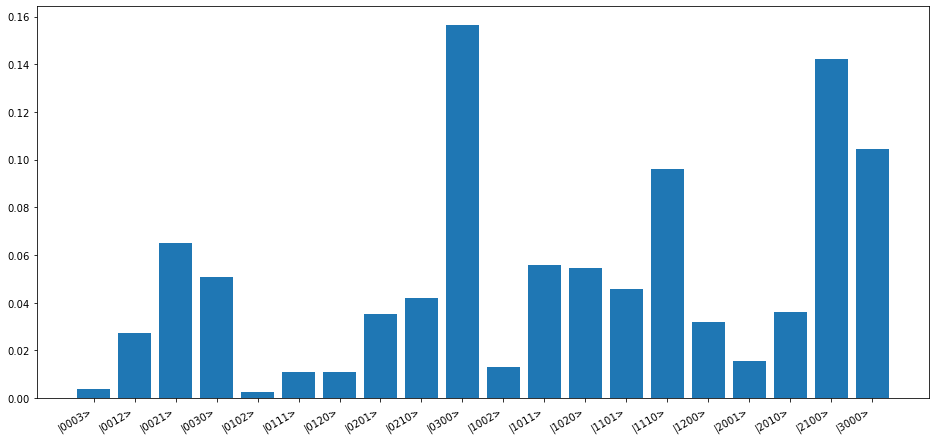

In [19]:
our_Probs = []
my_Modes = []
my_Modes2 = []

#find the all probs that not 0
for i in range(0,4):
    for j in range(0,4):
        for k in range(0,4):
            for l in range(0,4):
                if probs[i, j, k, l] != 0:
                    our_Probs.append(probs[i, j, k, l])
                    my_Modes.append("|" + str(i) +  str(j) +  str(k) +  str(l) + ">")
                    print(my_Modes[-1] + ":", probs[i, j, k, l])
                    my_Modes2.append(str(i) + str(j) + str(k) + str(l))

fig = plt.figure(figsize=(16,8))                    
plt.bar(my_Modes, our_Probs)
fig.autofmt_xdate()
plt.show()


In [20]:
start_My_VonNuemann_Time = time.time()

#Von-Nuemann Algorithm
code = ''
S1 = []
S2 = []
modes = my_Modes2
for k in range(len(modes)):
    for i in range(len(modes)):
        if i != (len(modes)-1):
            S1.append((modes[k]))
            S2.append((modes[i]))
        for j in range(len(modes[k])):
            if i == (len(modes)-1):
                break
            if (int(modes[k][j]) == 0) & (int(modes[i][j]) == 0):
                if j == 3:
                    code = code + ("/")
                    #print('code is: ', code)
                    break
            elif (int(modes[k][j]) == 0) & (int(modes[i][j]) != 0):
                code = code + '1'
                if j == 3:
                    code = code + ("/")
                    #print('code is: ', code)
                    break
            elif (int(modes[k][j]) != 0) & (int(modes[i][j]) == 0):
                code = code + '0'
                if j == 3:
                    code = code + ("/")
                    #print('code is: ', code)
                    break
            elif (int(modes[k][j]) != 0) & (int(modes[i][j]) != 0):
                if j == 3:
                    code = code + ("/")
                    #print('code is: ', code)
                    break

#we have shown (the states that don't generate code) with "/", then we split them by "/".
final_String = code.split("/")
#Remove empty strings from final String.
final_String[:] = [x for x in final_String if x]
#We count final String to get the probability of repeating them.
res = {}
for i in final_String:
    res[i] = final_String.count(i)

#Calculate Time of Von-Nuemann Algorithm
end_My_VonNuemann_Time = time.time()
my_VonNuemann_Time = end_My_VonNuemann_Time - start_My_VonNuemann_Time

print("The time of execution of Von-Nuemann is :", my_VonNuemann_Time)
print("Total execution time is :", my_BS_Time + my_VonNuemann_Time)


The time of execution of Von-Nuemann is : 0.006009817123413086
Total execution time is : 25.48203468322754


In [21]:
#We prepare Final String and find the probability
def prepareData(res):
    rn = list(res.keys())
    count_Of_No = list(res.values())
    probabilities = count_Of_No
    sum_No = 0
    for e in range(len(count_Of_No)):
        sum_No = sum_No + count_Of_No[e]

    for e in range(len(count_Of_No)):
        probabilities[e] = count_Of_No[e]/sum_No
    return (rn, probabilities)


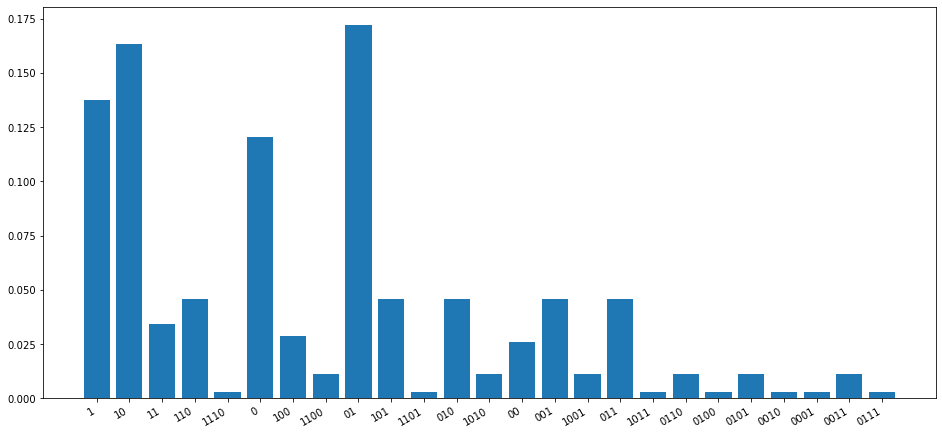

In [22]:
#We find the probability of any finalString.
my_Final_String, probabilities = prepareData(res)
fig = plt.figure(figsize=(16, 8))
plt.bar(range(len(res)), probabilities, tick_label=my_Final_String)
fig.autofmt_xdate()
plt.show()


In [23]:
# Creates a sorted dictionary (sorted by key)
def dictSorter(res):
    sorted_Res = dict(
        sorted(res.items(), key=lambda item: item[1], reverse=True))
    return sorted_Res


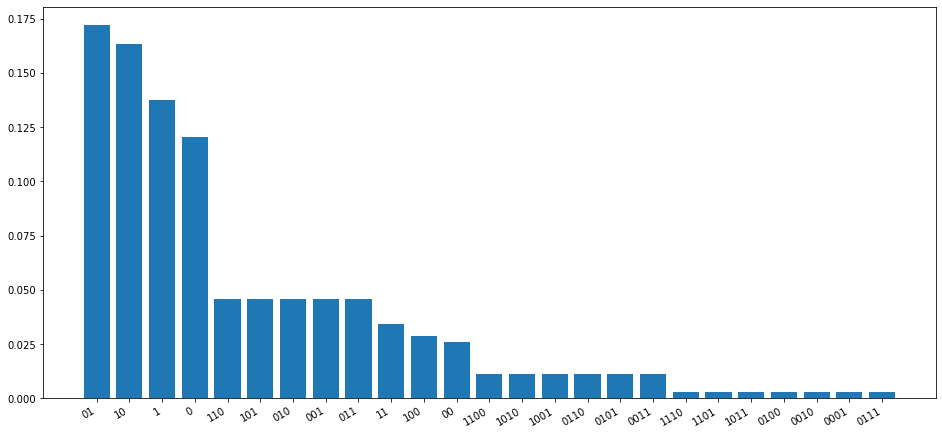

In [24]:
#We sorted them according to the obtained probability and then merged them together to get the final RandomNumber.
sorted_Res = dictSorter(res)
my_Final_String, probabilities = prepareData(sorted_Res)

fig = plt.figure(figsize=(16, 8))
plt.bar(range(len(sorted_Res)), probabilities, tick_label=my_Final_String)
fig.autofmt_xdate()
plt.show()


In [25]:
#We convert string to integer to create bits!
def strToInt(list_Of_String):
    str1 = ''
    my_List = []
    for i in range(len(list_Of_String)):
        str1 = str1 + list_Of_String[i]
    my_List = [int(i) for i in str1]
    return my_List


In [29]:
#my_Random_Number = final_String
my_Bits = strToInt(my_Final_String)
print(my_Bits)


[0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1]


In [32]:
print('S1:\n', S1)
print('\n')
print('S2:\n', S2)
print('\n')
print('coding:\n', code)
print('\n')
print('Final String:\n', final_String)
print('\n')
print('count of every Strings:\n', res)
print('\n')
#######################################
input_Data = open('input_Data.txt', 'w')
input_Data.write('S1:\n')
for s1 in range(len(S1)):
    input_Data.write('[' + str(S1[s1]) + ']')
input_Data.write('\n\n')
input_Data.write('S2:\n')
for s2 in range(len(S2)):
    input_Data.write('[' + str(S2[s2]) + ']')
input_Data.write('\n\n')
input_Data.write('coding:\n')
for c in range(len(code)):
    input_Data.write(str(code[c]))
input_Data.write('\n\n')
input_Data.write('Final Strings:\n')
for fs in range(len(final_String)):
    input_Data.write('[' + str(final_String[fs]) + ']')
input_Data.close()
#######################################
output_File = open('QRN.txt', 'w')
output_File.write('')

# seed random number generator and shuffle final String
#befor_Shuffle_RN = my_Random_Number
#seed(1)
#shuffle(befor_Shuffle_RN)
#We convert string to integer to create bits!
#my_Random_Number = strToInt(my_Bits)

for b in range(len(my_Bits)):
    output_File.write(str(my_Bits[b]))
output_File.close()
#######################################


S1:
 ['0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0003', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0012', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0021', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0030', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0102', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0111', '0120', '0120', '0120', '0120', '0120', '0120', '0120', '0120', '0120', '0120', '0

In [34]:
# sp_800_approximate_entropy_test.py
#
# Copyright (C) 2017 David Johnston
# This program is distributed under the terms of the GNU General Public License.
#
# This file is part of sp800_22_tests.
#
# sp800_22_tests is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# sp800_22_tests is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with sp800_22_tests.  If not, see <http://www.gnu.org/licenses/>.
from __future__ import print_function

import math
from scipy.special import gamma, gammainc, gammaincc
#from gamma_functions import *

def bits_to_int(bits):
    theint = 0
    for i in range(len(bits)):
        theint = (theint << 1) + bits[i]
    return theint
        
def approximate_entropy_test(bits):
    n = len(bits)
    
    m = int(math.floor(math.log(n,2)))-6
    if m < 2:
        m = 2
    if m >3 :
        m = 3
        
    print("  n         = ",n)
    print("  m         = ",m)
    
    Cmi = list()
    phi_m = list()
    for iterm in range(m,m+2):
        # Step 1 
        padded_bits=bits+bits[0:iterm-1]
    
        # Step 2
        counts = list()
        for i in range(2**iterm):
            #print "  Pattern #%d of %d" % (i+1,2**iterm)
            count = 0
            for j in range(n):
                if bits_to_int(padded_bits[j:j+iterm]) == i:
                    count += 1
            counts.append(count)
            print("  Pattern %d of %d, count = %d" % (i+1,2**iterm, count))
    
        # step 3
        Ci = list()
        for i in range(2**iterm):
            Ci.append(float(counts[i])/float(n))
        
        Cmi.append(Ci)
    
        # Step 4
        sum = 0.0
        for i in range(2**iterm):
            if (Ci[i] > 0.0):
                sum += Ci[i]*math.log((Ci[i]/10.0))
        phi_m.append(sum)
        print("  phi(%d)    = %f" % (m,sum))
        
    # Step 5 - let the loop steps 1-4 complete
    
    # Step 6
    appen_m = phi_m[0] - phi_m[1]
    print("  AppEn(%d)  = %f" % (m,appen_m))
    chisq = 2*n*(math.log(2) - appen_m)
    print("  ChiSquare = ",chisq)
    # Step 7
    p = gammaincc(2**(m-1),(chisq/2.0))
    
    success = (p >= 0.01)
    return (success, p, None)

if __name__ == "__main__":
    bits = my_Bits
    success, p, _ = approximate_entropy_test(bits)
    
    print("success =",success)
    print("p = ",p)


  n         =  80
  m         =  2
  Pattern 1 of 4, count = 15
  Pattern 2 of 4, count = 24
  Pattern 3 of 4, count = 24
  Pattern 4 of 4, count = 17
  phi(2)    = -3.667962
  Pattern 1 of 8, count = 7
  Pattern 2 of 8, count = 8
  Pattern 3 of 8, count = 14
  Pattern 4 of 8, count = 10
  Pattern 5 of 8, count = 8
  Pattern 6 of 8, count = 16
  Pattern 7 of 8, count = 10
  Pattern 8 of 8, count = 7
  phi(2)    = -4.336190
  AppEn(2)  = 0.668228
  ChiSquare =  3.9870830131765267
success = True
p =  0.4077567963322679
